# BigQuery Demo – COVID-19 (Portfolio)

This notebook runs BigQuery SQL against the public dataset  
`bigquery-public-data.covid19_open_data.covid19_open_data` and shows quick results for Serbia, Norway, and Germany.

**What you’ll see**
- 7-day moving average of new cases (by country)
- Incidence per 100k (7-day average)
- Top-10 countries by incidence on a given date (parameterized)
- Peak (max) 7-day average per country

> Prereqs (once):  
> `pip install google-cloud-bigquery pandas pyarrow matplotlib`  
> Auth: `gcloud auth application-default login`


In [20]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import os

PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT", "charged-city-421819")
client = bigquery.Client(project=PROJECT_ID)
print("Using project:", client.project)

# Countries to focus on in plots
FOCUS = ["Serbia", "Norway", "Germany"]

pd.options.display.float_format = "{:,.2f}".format


Using project: charged-city-421819


In [21]:
def run_sql(query: str, params: list = None) -> pd.DataFrame:
    job_config = bigquery.QueryJobConfig()
    if params:
        job_config.query_parameters = params
    return client.query(query, job_config=job_config).result().to_dataframe()


## 1) Daily new cases (7-day moving average)

In [22]:
sql_daily_7d = """
WITH base AS (
  SELECT
    date,
    country_name,
    new_confirmed AS new_cases
  FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE country_name IS NOT NULL
    AND new_confirmed IS NOT NULL
)
SELECT
  date,
  country_name,
  new_cases,
  AVG(new_cases) OVER (
    PARTITION BY country_name
    ORDER BY date
    ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
  ) AS new_cases_7d_avg
FROM base
"""

df_daily_7d = run_sql(sql_daily_7d)
df_daily_7d.head()


,date,country_name,new_cases,new_cases_7d_avg
0,2020-01-06,American Samoa,0,0.00
1,2020-01-31,American Samoa,0,0.00
2,2020-02-08,American Samoa,0,0.00
3,2020-02-16,American Samoa,0,0.00
4,2020-03-18,American Samoa,0,0.00


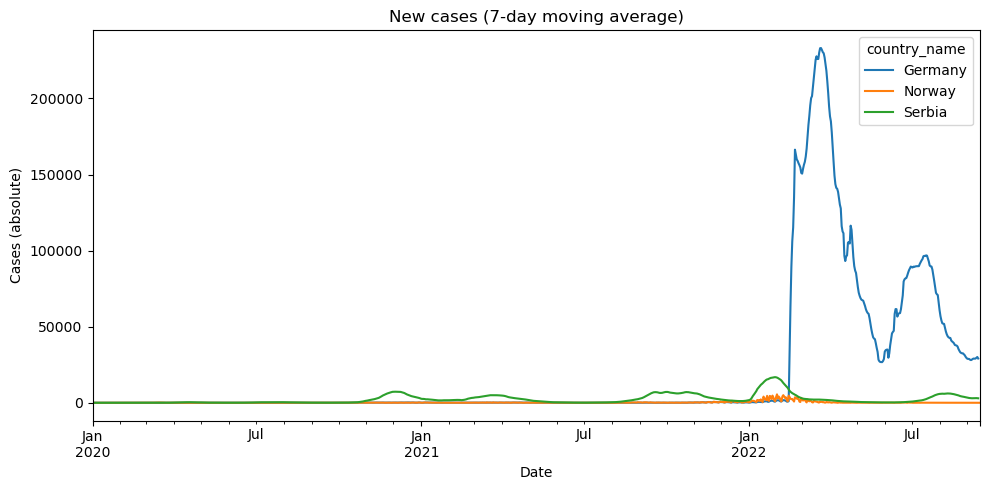

In [23]:
subset = df_daily_7d[df_daily_7d["country_name"].isin(FOCUS)].copy()
# ensure date dtype
subset["date"] = pd.to_datetime(subset["date"])
pivot = subset.pivot_table(index="date", columns="country_name", values="new_cases_7d_avg", aggfunc="mean")

ax = pivot.plot(figsize=(10,5))
ax.set_title("New cases (7-day moving average)")
ax.set_xlabel("Date")
ax.set_ylabel("Cases (absolute)")
plt.tight_layout()
plt.show()


## 2) Incidence per 100k (7-day average)

In [ ]:
sql_incidence_7d = """
WITH enriched AS (
  SELECT
    date,
    country_name,
    confirmed,
    population
  FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE country_name IS NOT NULL
    AND confirmed IS NOT NULL
    AND population IS NOT NULL AND population > 0
)
SELECT
  date,
  country_name,
  confirmed,
  ROUND(confirmed * 100000.0 / population, 6) AS new_per_100k,
  ROUND(
    AVG(confirmed) OVER (
      PARTITION BY country_name
      ORDER BY date
      ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) * 100000.0 / population, 6
  ) AS new_per_100k_7d_avg
FROM enriched
"""

df_inc_7d = run_sql(sql_incidence_7d)
df_inc_7d.head()


,date,country_name,new_confirmed,new_per_100k,new_per_100k_7d_avg
0,2020-07-23,United States of America,68,26.57,4.30
1,2020-07-23,United States of America,147,12.05,2.81
2,2020-07-23,United States of America,21,27.63,61.66
3,2020-07-23,United States of America,60,70.86,62.42
4,2020-07-23,United States of America,37,23.97,5.92


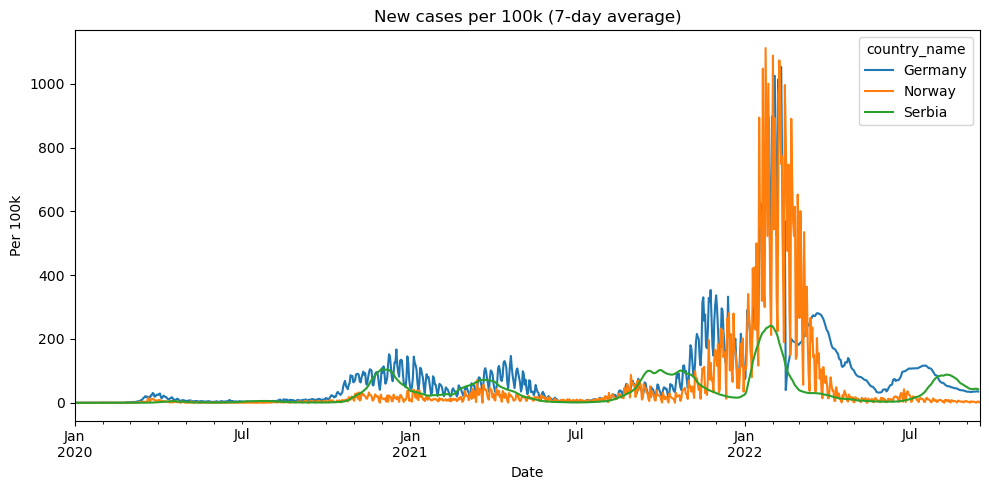

In [25]:
subset_i = df_inc_7d[df_inc_7d["country_name"].isin(FOCUS)].copy()
subset_i["date"] = pd.to_datetime(subset_i["date"])
pivot_i = subset_i.pivot_table(index="date", columns="country_name", values="new_per_100k_7d_avg", aggfunc="mean")

ax = pivot_i.plot(figsize=(10,5))
ax.set_title("New cases per 100k (7-day average)")
ax.set_xlabel("Date")
ax.set_ylabel("Per 100k")
plt.tight_layout()
plt.show()


## 3) Top-10 countries by incidence on a selected date

In [26]:
target_date = date(2021, 12, 1)  # change as you wish

sql_top10 = """
WITH x AS (
  SELECT
    date,
    country_name,
    population,
    new_confirmed,
    AVG(new_confirmed) OVER (
      PARTITION BY country_name
      ORDER BY date
      ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS new_7d
  FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE population IS NOT NULL AND population > 0
)
SELECT
  country_name,
  ROUND(new_7d * 100000.0 / population, 2) AS new_per_100k_7d
FROM x
WHERE date = @target_date
ORDER BY new_per_100k_7d DESC
LIMIT 10
"""

params = [bigquery.ScalarQueryParameter("target_date", "DATE", target_date)]
df_top10 = run_sql(sql_top10, params=params)
df_top10


,country_name,new_per_100k_7d
0,Spain,"7,347,959.18"
1,Norway,"5,958,888.89"
2,Spain,"1,318,864.47"
3,Spain,"1,184,313.73"
4,Spain,"957,638.89"
5,Colombia,"608,333.33"
6,Spain,"458,241.76"
7,United States of America,"378,282.24"
8,Spain,"368,684.21"
9,United States of America,"320,723.72"


## 4) Peak (max) 7-day average per country


In [27]:
sql_peak = """
WITH x AS (
  SELECT
    date, country_name, population, new_confirmed,
    AVG(new_confirmed) OVER (
      PARTITION BY country_name
      ORDER BY date
      ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS new_7d
  FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE population IS NOT NULL AND population > 0
),
ranked AS (
  SELECT
    country_name,
    date,
    new_7d,
    DENSE_RANK() OVER (PARTITION BY country_name ORDER BY new_7d DESC) AS rnk
  FROM x
)
SELECT country_name, date AS peak_date, ROUND(new_7d,2) AS peak_new_7d
FROM ranked
WHERE rnk = 1
ORDER BY peak_new_7d DESC
"""

df_peak = run_sql(sql_peak)
df_peak.head(15)


,country_name,peak_date,peak_new_7d
0,Netherlands,2022-08-01,"2,020,249.00"
1,South Korea,2022-03-15,"621,328.00"
2,South Korea,2022-03-15,"621,328.00"
3,South Korea,2022-03-15,"621,328.00"
4,South Korea,2022-03-15,"621,328.00"
5,South Korea,2022-03-15,"621,328.00"
6,South Korea,2022-03-16,"621,328.00"
7,Germany,2022-03-22,"307,873.00"
8,Germany,2022-03-22,"307,873.00"
9,Germany,2022-03-22,"307,873.00"


## Save outputs


In [ ]:
os.makedirs("../outputs", exist_ok=True)
df_daily_7d.to_csv("../outputs/daily_7d_avg.csv", index=False)
df_inc_7d.to_csv("../outputs/incidence_7d.csv", index=False)
df_top10.to_csv(f"../outputs/top10_incidence_{target_date.isoformat()}.csv", index=False)
df_peak.to_csv("../outputs/peak_dates.csv", index=False)

print("Saved CSVs in ../outputs/")


NameError: name 'df_daily_7d' is not defined

## Notes
- This notebook uses Application Default Credentials (`gcloud auth application-default login`).
- You can move the SQL strings to `.sql` files in `bq/sql/` and read them with:
  ```python
  query = open("bq/sql/01_daily_7d_avg.sql").read()
  run_sql(query)
